In [143]:
import numpy as np
import matplotlib.pyplot as plt


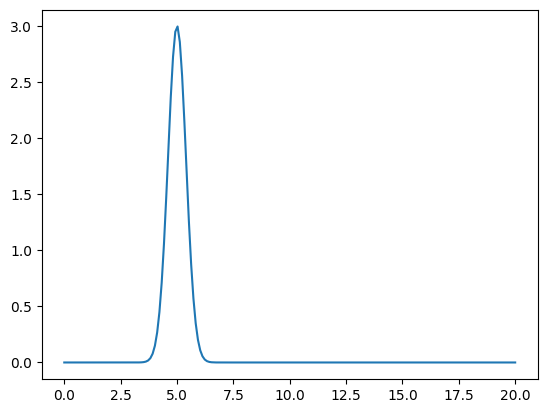

In [144]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = 0.2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u = np.zeros((nt, nx)) 


u[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u[0, 0] = u[0,-2]
u[0, -1] = u[0, 1]
u[0,:]

plt.plot(x, u[0,:])

In [145]:
for j in range(0, nt-1):
    # we need arrays for each k stage:
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)

    for i in range(1, nx-1):
        k1[i] =  -c * (u[j, i] - u[j, i-1]) / dx
    
    # k2s:
    u_temp = u[j,:] + (dt/2)*k1
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k2[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx

    # k3s:
    u_temp = u[j,:] + (dt/2)*k2
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k3[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
    
    # k4s:
    u_temp = u[j, :] + dt * k3
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        k4[i] = -c * (u_temp[i] - u_temp[i-1]) / dx
    
    u[j+1, :] = u[j, :] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    u[j+1, 0] = u[j+1, -2] # periodic
    u[j+1, -1] = u[j+1, 1]

    if j % 100 == 0:
        total_mass = np.sum(u[j, 1:-1]) * dx  # Only interior points
        print(f"j={j}, total mass={total_mass:.4f}")


j=0, total mass=3.0080
j=100, total mass=3.0080
j=200, total mass=3.0080
j=300, total mass=3.0080
j=400, total mass=3.0080


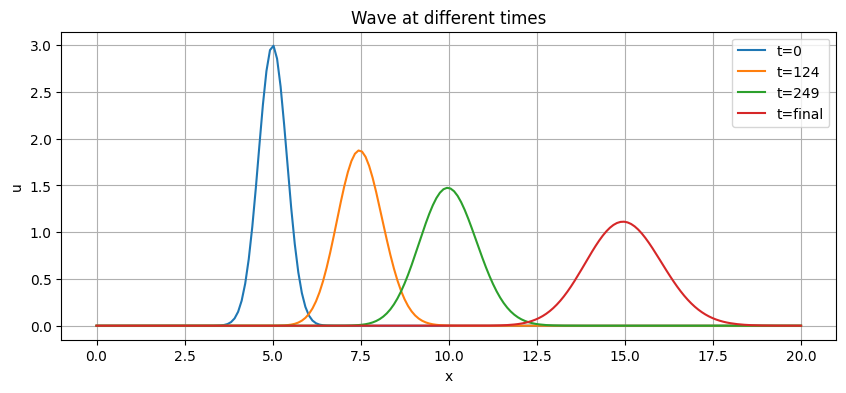

In [146]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('Wave at different times')
plt.show()

In [147]:
t0_peak_height = np.max(u[0,:])

In [148]:
max_heights = np.zeros(nt)
for j in range(nt):
    max_heights[j] = np.max(u[j,:])

Text(0.5, 1.0, 'Peak height error over time')

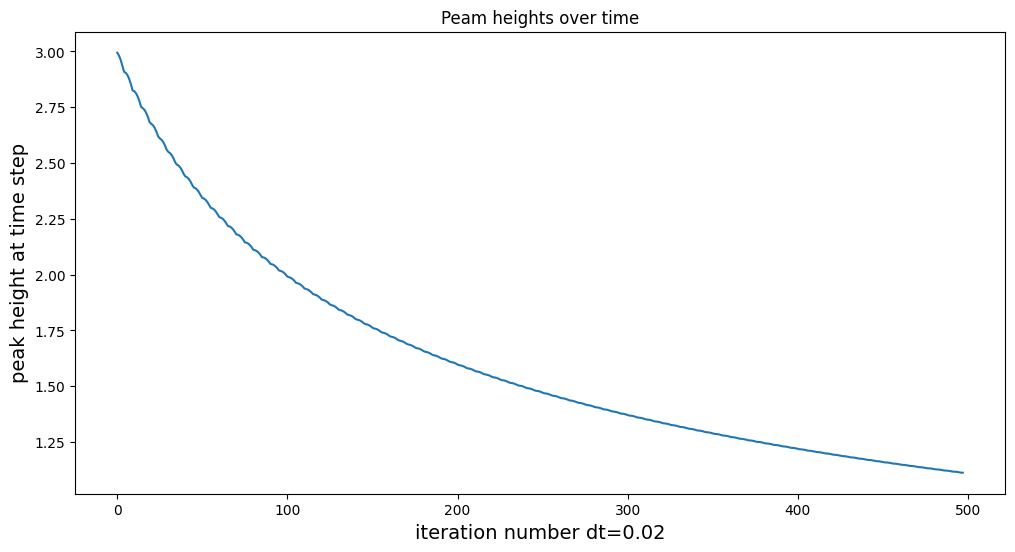

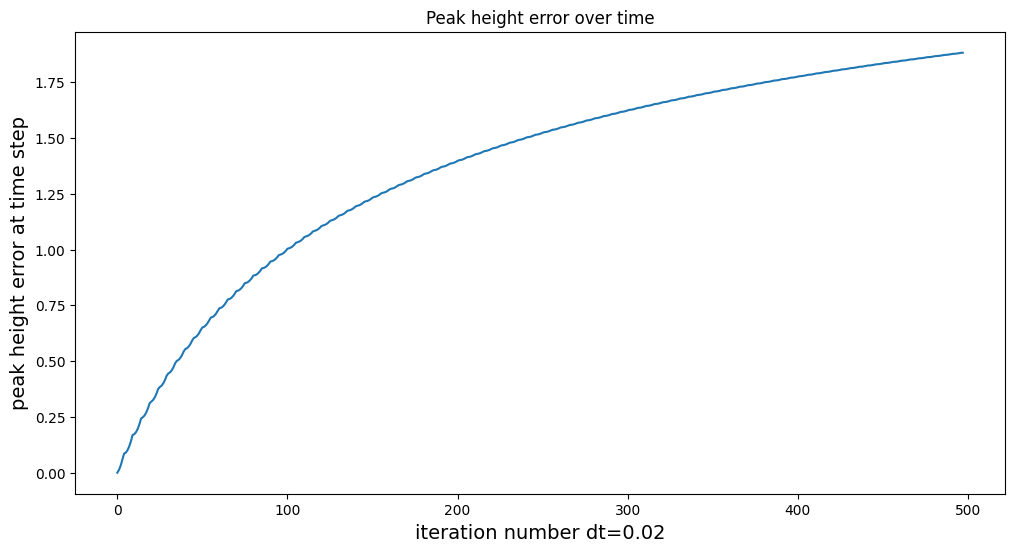

In [149]:
plt.figure(figsize=(12,6))
plt.plot(max_heights)
plt.xlabel(f'iteration number dt={round(dt,3)}', fontsize=14)
plt.ylabel(f'peak height at time step', fontsize = 14)
plt.title('Peam heights over time')


plt.figure(figsize=(12,6))
plt.plot(np.abs(t0_peak_height-max_heights))
plt.xlabel(f'iteration number dt={round(dt,3)}', fontsize=14)
plt.ylabel(f'peak height error at time step', fontsize = 14)
plt.title('Peak height error over time')



In [150]:
def exact_solution(x, t_val, c, sigma, amplitude, x0_init):
    """Exact solution: shifted Gaussian"""
    center = x0_init + c * t_val  # Center moves with velocity c
    return amplitude * np.exp(-((x - center)**2) / (2*sigma**2))

def compute_width(u_slice, x):
    """Width (standard deviation)"""
    total = np.sum(u_slice)
    if total < 1e-10:
        return 0
    x_mean = np.sum(x * u_slice) / total
    variance = np.sum((x - x_mean)**2 * u_slice) / total
    return np.sqrt(variance)

# Compute all metrics
peak_heights = np.zeros(nt)
widths = np.zeros(nt)
L2_errors = np.zeros(nt)
total_mass = np.zeros(nt)


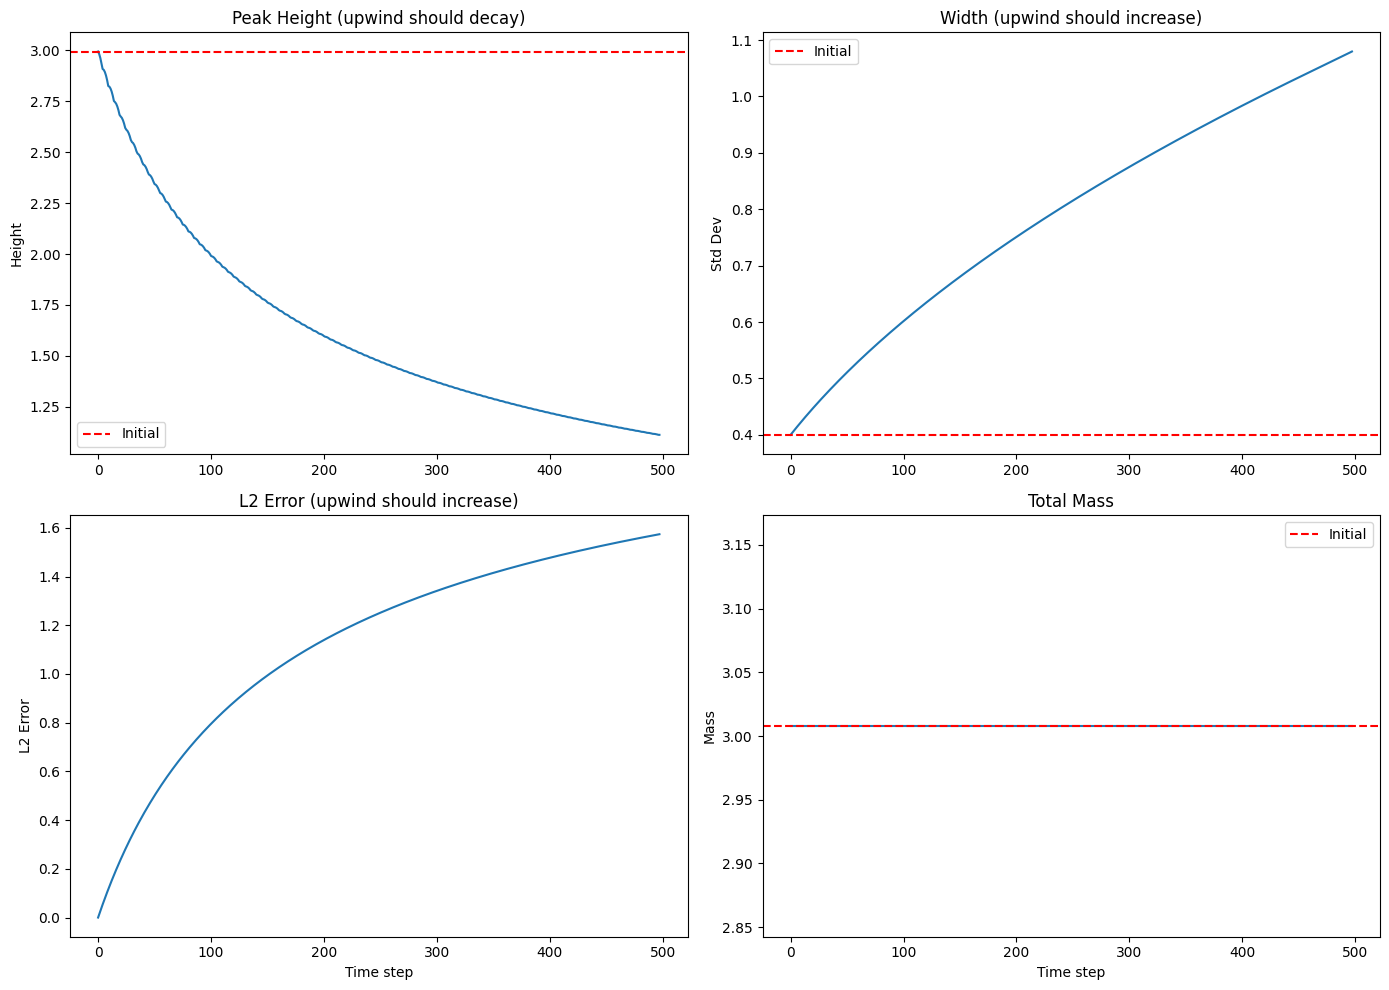

In [151]:

for j in range(nt):
    peak_heights[j] = np.max(u[j,:])
    widths[j] = compute_width(u[j,:], x)
    u_exact = exact_solution(x, t[j], c, sigma, amplitude, x0)
    L2_errors[j] = np.sqrt(dx * np.sum((u[j,:] - u_exact)**2))
    total_mass[j] = np.sum(u[j, 1:-1]) * dx  # Exclude boundaries

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(peak_heights)
axes[0,0].axhline(peak_heights[0], color='r', linestyle='--', label='Initial')
axes[0,0].set_title('Peak Height (upwind should decay)')
axes[0,0].set_ylabel('Height')
axes[0,0].legend()

axes[0,1].plot(widths)
axes[0,1].axhline(widths[0], color='r', linestyle='--', label='Initial')
axes[0,1].set_title('Width (upwind should increase)')
axes[0,1].set_ylabel('Std Dev')
axes[0,1].legend()

axes[1,0].plot(L2_errors)
axes[1,0].set_title('L2 Error (upwind should increase)')
axes[1,0].set_ylabel('L2 Error')
axes[1,0].set_xlabel('Time step')

axes[1,1].plot(total_mass)
axes[1,1].axhline(total_mass[0], color='r', linestyle='--', label='Initial')
axes[1,1].set_title('Total Mass')
axes[1,1].set_ylabel('Mass')
axes[1,1].set_xlabel('Time step')
axes[1,1].legend()

plt.tight_layout()

## FTCS (i know it will fail)

$$u^{j+1}_i = u_i^j + \frac{\Delta t}{2 \Delta x}(u^j_{i+1} - u^j_{i-1})$$

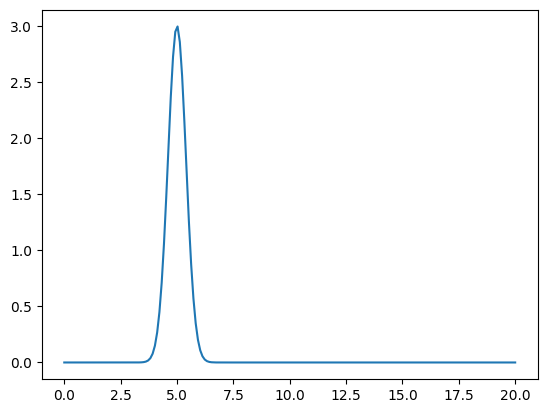

In [152]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = .2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_FTCS = np.zeros((nt, nx)) 


u_FTCS[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_FTCS[0, 0] = u_FTCS[0,-2]
u_FTCS[0, -1] = u_FTCS[0, 1]
u_FTCS[0,:]

plt.plot(x, u_FTCS[0,:])

In [153]:
for j in range(0, nt-1):
    for i in range(1, nx-1):
        u_FTCS[j+1, i] = u_FTCS[j, i] - (c*dt)/(2*dx) * (u_FTCS[j, i+1] - u_FTCS[j, i-1])

    #periodic BCs:
    u_FTCS[j+1, 0] = u_FTCS[j+1, -2]
    u_FTCS[j+1, -1] = u_FTCS[j+1, 1]


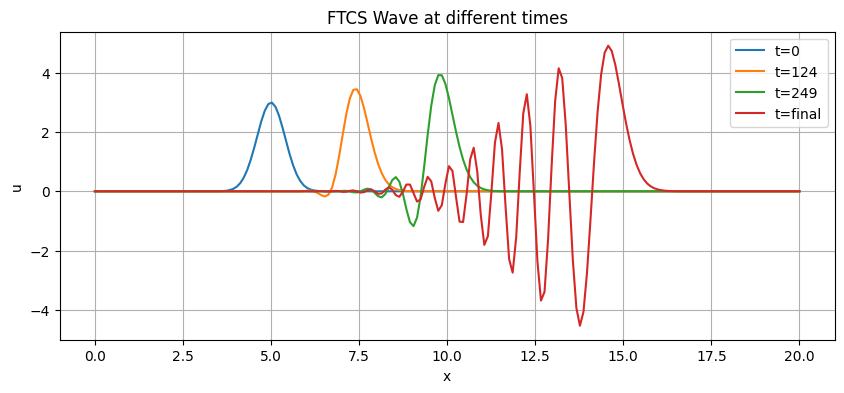

In [154]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u_FTCS[0, :], label='t=0')
plt.plot(x, u_FTCS[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_FTCS[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_FTCS[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('FTCS Wave at different times')
plt.show()

## 2nd order:

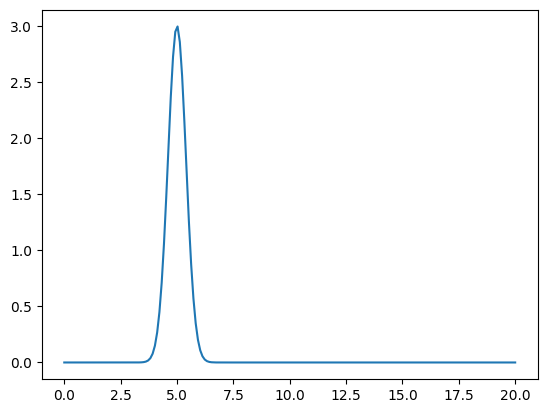

In [155]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = 0.2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_2nd_order = np.zeros((nt, nx)) 


u_2nd_order[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_2nd_order[0, 0] = u_2nd_order[0,-2]
u_2nd_order[0, -1] = u_2nd_order[0, 1]
u_2nd_order[0,:]

plt.plot(x, u_2nd_order[0,:])

In [156]:
for j in range(0, nt-1):
    # we need arrays for each k stage:
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)

    for i in range(1, nx-1):
        if i ==1:
            k1[i] =  -c * (u_2nd_order[j, i] - u_2nd_order[j, i-1]) / dx
        else:
            k1[i] =  -c * (3*u_2nd_order[j, i] - 4*u_2nd_order[j, i-1] + u_2nd_order[j,i-2]) / (2*dx)
    
    # k2s:
    u_temp = u_2nd_order[j,:] + (dt/2)*k1
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k2[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k2[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)

    # k3s:
    u_temp = u_2nd_order[j,:] + (dt/2)*k2
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k3[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k3[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)
    
    # k4s:
    u_temp = u_2nd_order[j, :] + dt * k3
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i == 1:
            k4[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k4[i] = -c * (3*u_temp[i] - 4*u_temp[i-1] + u_temp[i-2]) / (2*dx)
    
    u_2nd_order[j+1, :] = u_2nd_order[j, :] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    u_2nd_order[j+1, 0] = u_2nd_order[j+1, -2] # periodic
    u_2nd_order[j+1, -1] = u_2nd_order[j+1, 1]

    if j % 100 == 0:
        total_mass = np.sum(u_2nd_order[j, 1:-1]) * dx  # Only interior points
        print(f"j={j}, total mass={total_mass:.4f}")


j=0, total mass=3.0080
j=100, total mass=3.0080
j=200, total mass=3.0080
j=300, total mass=3.0080
j=400, total mass=3.0080


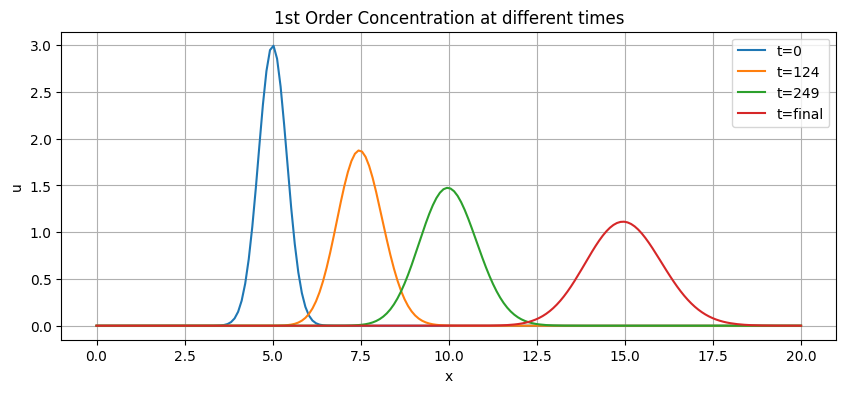

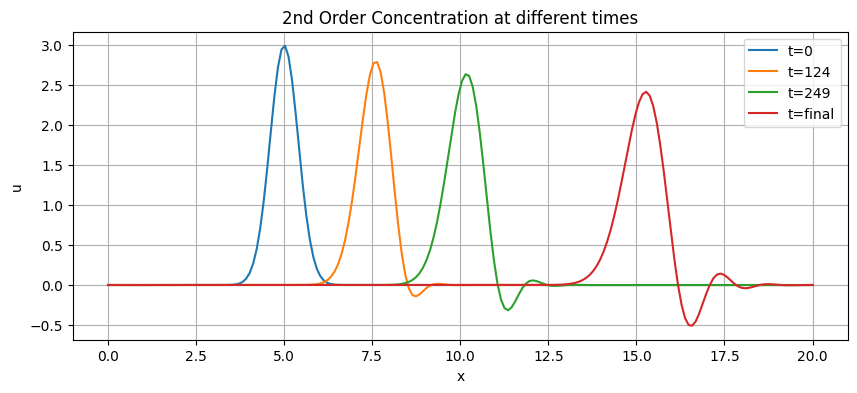

In [157]:

# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(10, 4))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

## 3rd Order:

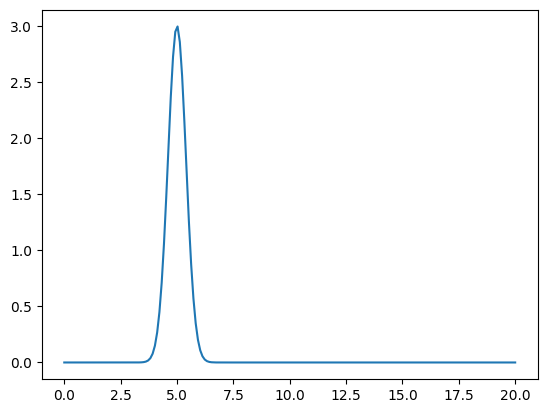

In [158]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10

## discretization stuff:
nx = 200
dx = L / (nx - 1)

dt = 0.2*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_3rd_order = np.zeros((nt, nx)) 


u_3rd_order[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_3rd_order[0, 0] = u_3rd_order[0,-2]
u_3rd_order[0, -1] = u_3rd_order[0, 1]
u_3rd_order[0,:]

plt.plot(x, u_3rd_order[0,:])

In [159]:
for j in range(0, nt-1):
    # we need arrays for each k stage:
    k1 = np.zeros(nx)
    k2 = np.zeros(nx)
    k3 = np.zeros(nx)
    k4 = np.zeros(nx)

    for i in range(1, nx-1):
        if i <= 2:
            ## first order:
            k1[i] =  -c * (u_3rd_order[j, i] - u_3rd_order[j, i-1]) / dx
        else:
            k1[i] =  -c * (11*u_3rd_order[j,i] - 18*u_3rd_order[j,i-1] + 9*u_3rd_order[j,i-2] - 2*u_3rd_order[j,i-3])/(6*dx)
    
    # k2s:
    u_temp = u_3rd_order[j,:] + (dt/2)*k1
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i <= 2:
            k2[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k2[i] = -c * (11*u_temp[i] - 18*u_temp[i-1] + 9*u_temp[i-2] - 2*u_temp[i-3])/(6*dx)

    # k3s:
    u_temp = u_3rd_order[j,:] + (dt/2)*k2
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i <= 2:
            k3[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k3[i] = -c * (11*u_temp[i] - 18*u_temp[i-1] + 9*u_temp[i-2] - 2*u_temp[i-3])/(6*dx)

    # k4s:
    u_temp = u_3rd_order[j, :] + dt * k3
    u_temp[0] = u_temp[-2] # periodic
    u_temp[-1] = u_temp[1]
    for i in range(1, nx-1):
        if i <= 2:
            k4[i] =  -c * (u_temp[i] - u_temp[i-1]) / dx
        else:
            k4[i] = -c * (11*u_temp[i] - 18*u_temp[i-1] + 9*u_temp[i-2] - 2*u_temp[i-3])/(6*dx)

    u_3rd_order[j+1, :] = u_3rd_order[j, :] + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    u_3rd_order[j+1, 0] = u_3rd_order[j+1, -2] # periodic
    u_3rd_order[j+1, -1] = u_3rd_order[j+1, 1]

    if j % 100 == 0:
        total_mass = np.sum(u_3rd_order[j, 1:-1]) * dx  # Only interior points
        print(f"j={j}, total mass={total_mass:.4f}")


j=0, total mass=3.0080
j=100, total mass=3.0080
j=200, total mass=3.0080
j=300, total mass=3.0081
j=400, total mass=3.0432


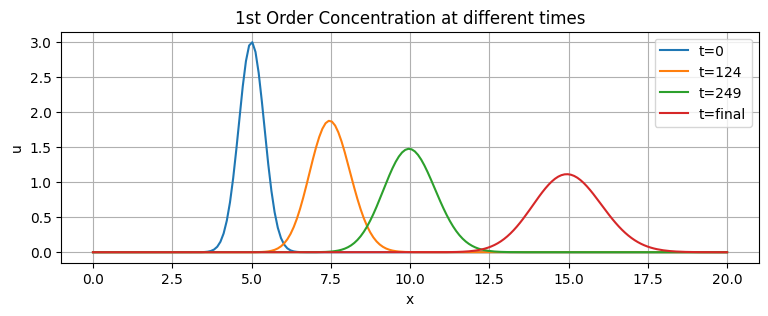

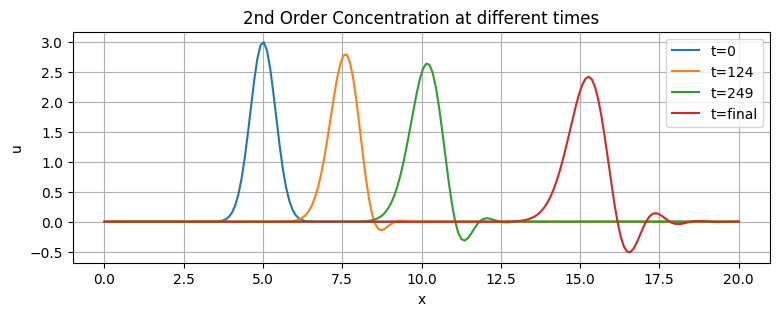

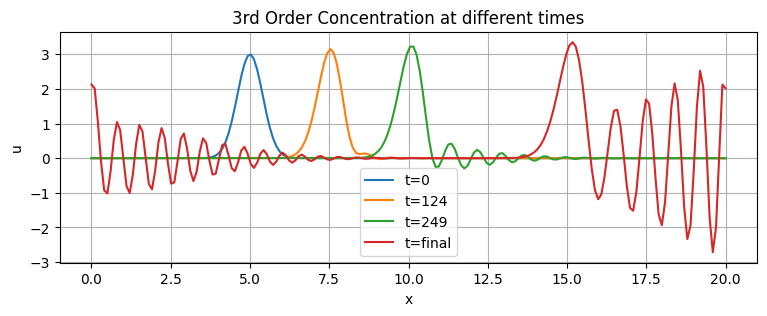

In [160]:

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_3rd_order[0, :], label='t=0')
plt.plot(x, u_3rd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_3rd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_3rd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('3rd Order Concentration at different times')
plt.show()

## Lax-wendroff

she lax-wendroff on my dihh

$$u^{j+1}_{i} = u_i^j = \frac{r}{2}(u_{i+1}^j) - \frac{r}{2}(u^j_{i+1} - u^j_{i-1}) + \frac{r^2}{2}(u^j_{i+1} - 2_i^j + u^j_{i-1})$$

with stability condition: $r \leq 1$

and $r=\frac{c \Delta t}{\Delta x}$

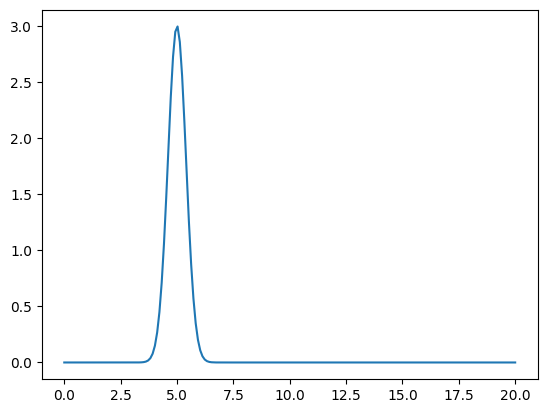

In [161]:
## parameters:
L = 20.0
c = 1.0

## IC
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10

## discretization stuff:
nx = 200
dx = L / (nx - 1)

r=0.2
dt = r*dx/c
nt = int(t_final/dt) + 1


t = np.linspace(0, t_final, nt)

##

## arrays and such:
x = np.linspace(0, L, nx)
t = np.linspace(0, t_final, nt)

u_LW = np.zeros((nt, nx)) 


u_LW[0,:] = amplitude*np.exp(-(x-x0)**2/(2*sigma**2))

# Apply periodic boundary conditions
u_LW[0, 0] = u_LW[0,-2]
u_LW[0, -1] = u_LW[0, 1]
u_LW[0,:]

plt.plot(x, u_LW[0,:])

In [162]:
for j in range(0, nt-1):
    for i in range(1, nx-1):
        u_LW[j+1, i] = u_LW[j, i] - (r/2)*(u_LW[j,i+1] - u_LW[j,i-1]) + (r**2 / 2)*(u_LW[j,i+1] - 2*u_LW[j,i] + u_LW[j,i-1]) 

    #periodic BCs:
    u_LW[j+1, 0] = u_LW[j+1, -2]
    u_LW[j+1, -1] = u_LW[j+1, 1]


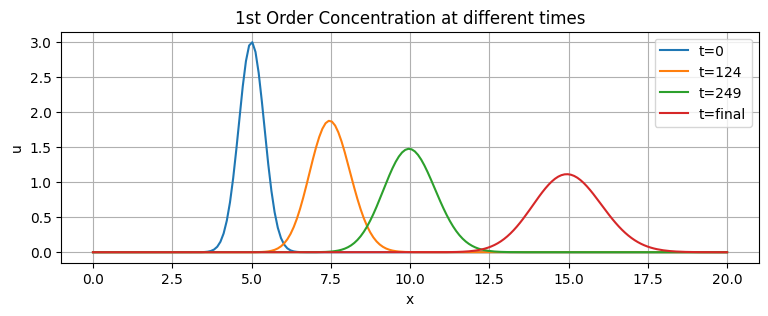

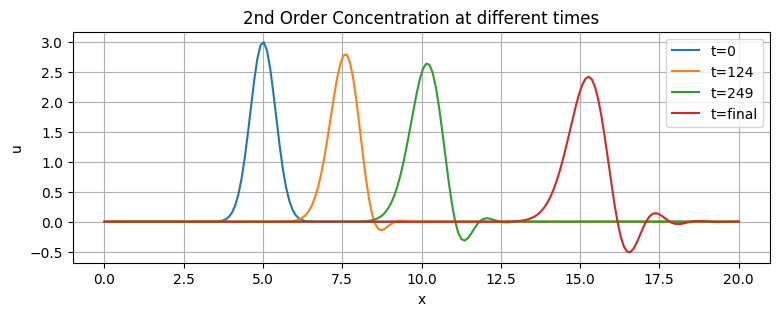

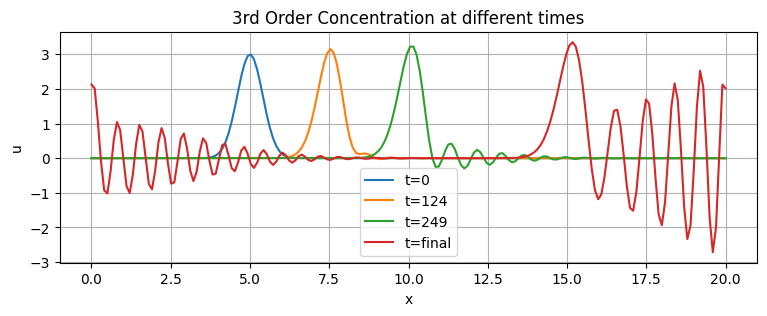

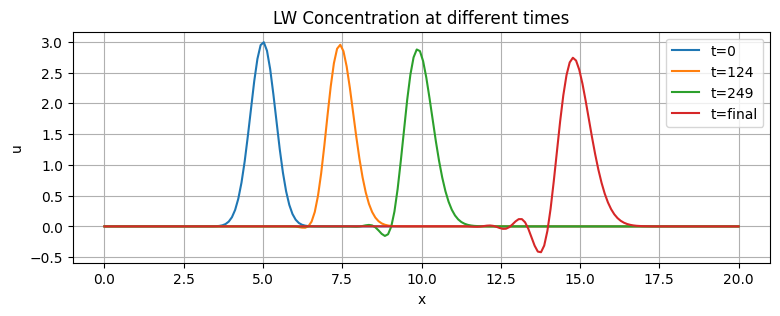

In [163]:

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_3rd_order[0, :], label='t=0')
plt.plot(x, u_3rd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_3rd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_3rd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('3rd Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_LW[0, :], label='t=0')
plt.plot(x, u_LW[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_LW[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_LW[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('LW Concentration at different times')
plt.show()

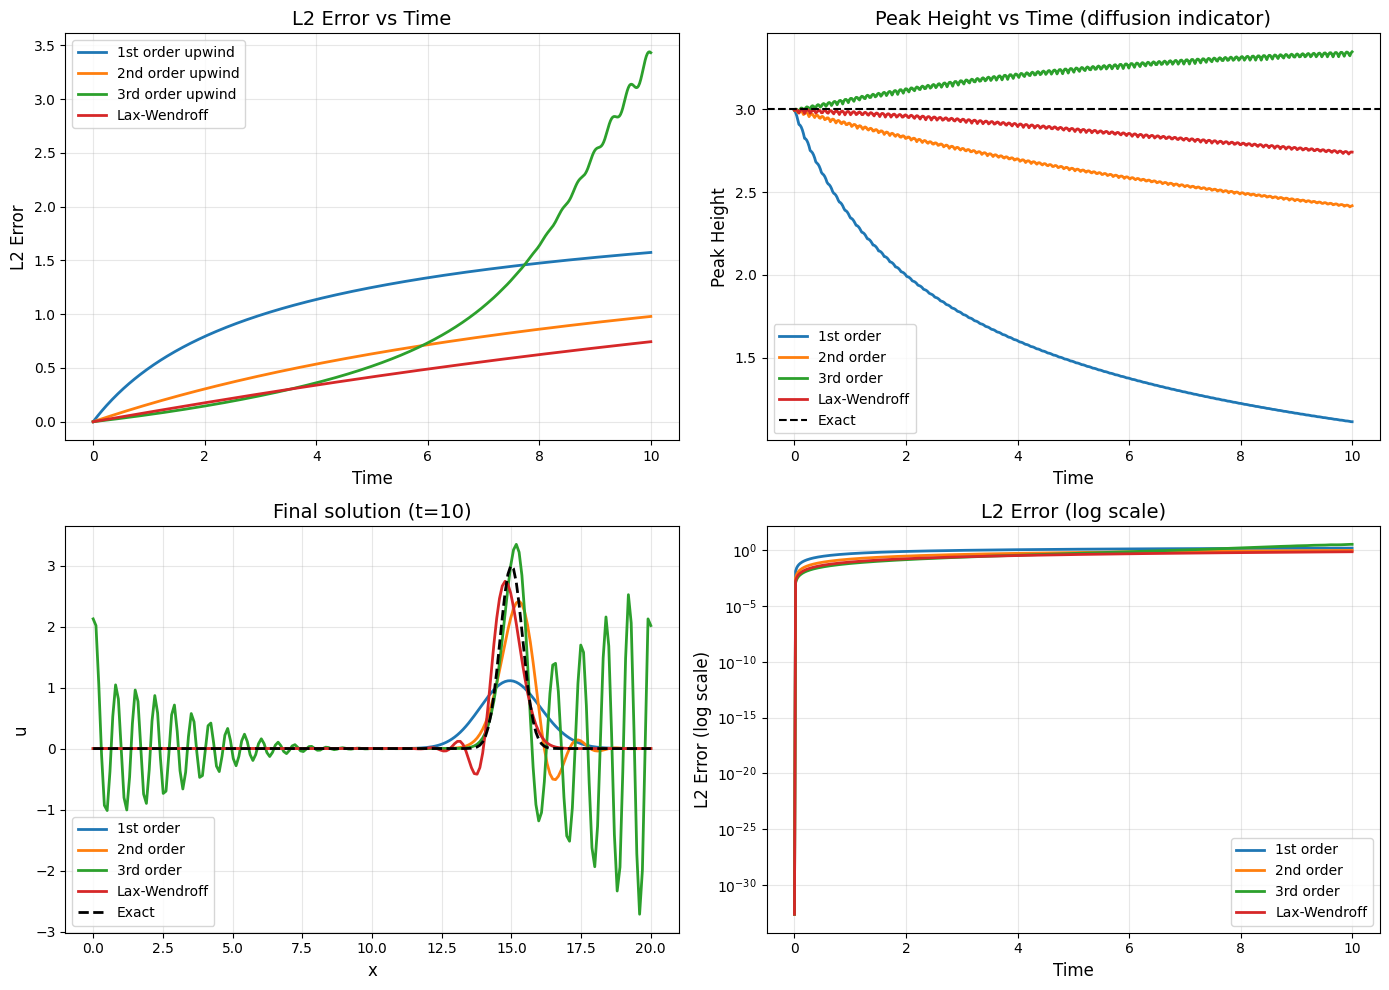

In [164]:
# Exact solution function
def exact_solution(x, t_val, c, sigma, amplitude, x0, L):
    """Exact solution: shifted Gaussian with periodic wrapping"""
    center = (x0 + c * t_val) % L  # Wrap around domain
    # Handle periodic wrapping for distance calculation
    dx_periodic = np.minimum(np.abs(x - center), L - np.abs(x - center))
    return amplitude * np.exp(-(dx_periodic**2) / (2*sigma**2))

# Compute L2 errors for all methods
L2_1st = np.zeros(nt)
L2_2nd = np.zeros(nt)
L2_3rd = np.zeros(nt)
L2_LW = np.zeros(nt)

for j in range(nt):
    u_exact = exact_solution(x, t[j], c, sigma, amplitude, x0, L)
    L2_1st[j] = np.sqrt(dx * np.sum((u[j,:] - u_exact)**2))
    L2_2nd[j] = np.sqrt(dx * np.sum((u_2nd_order[j,:] - u_exact)**2))
    L2_3rd[j] = np.sqrt(dx * np.sum((u_3rd_order[j,:] - u_exact)**2))
    L2_LW[j] = np.sqrt(dx * np.sum((u_LW[j,:] - u_exact)**2))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# L2 Error comparison
axes[0,0].plot(t, L2_1st, label='1st order upwind', linewidth=2)
axes[0,0].plot(t, L2_2nd, label='2nd order upwind', linewidth=2)
axes[0,0].plot(t, L2_3rd, label='3rd order upwind', linewidth=2)
axes[0,0].plot(t, L2_LW, label='Lax-Wendroff', linewidth=2)
axes[0,0].set_xlabel('Time', fontsize=12)
axes[0,0].set_ylabel('L2 Error', fontsize=12)
axes[0,0].set_title('L2 Error vs Time', fontsize=14)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Peak height comparison
peak_1st = np.array([np.max(u[j,:]) for j in range(nt)])
peak_2nd = np.array([np.max(u_2nd_order[j,:]) for j in range(nt)])
peak_3rd = np.array([np.max(u_3rd_order[j,:]) for j in range(nt)])
peak_LW = np.array([np.max(u_LW[j,:]) for j in range(nt)])

axes[0,1].plot(t, peak_1st, label='1st order', linewidth=2)
axes[0,1].plot(t, peak_2nd, label='2nd order', linewidth=2)
axes[0,1].plot(t, peak_3rd, label='3rd order', linewidth=2)
axes[0,1].plot(t, peak_LW, label='Lax-Wendroff', linewidth=2)
axes[0,1].axhline(amplitude, color='k', linestyle='--', label='Exact')
axes[0,1].set_xlabel('Time', fontsize=12)
axes[0,1].set_ylabel('Peak Height', fontsize=12)
axes[0,1].set_title('Peak Height vs Time (diffusion indicator)', fontsize=14)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Final snapshot comparison
axes[1,0].plot(x, u[-1,:], label='1st order', linewidth=2)
axes[1,0].plot(x, u_2nd_order[-1,:], label='2nd order', linewidth=2)
axes[1,0].plot(x, u_3rd_order[-1,:], label='3rd order', linewidth=2)
axes[1,0].plot(x, u_LW[-1,:], label='Lax-Wendroff', linewidth=2)
u_exact_final = exact_solution(x, t[-1], c, sigma, amplitude, x0, L)
axes[1,0].plot(x, u_exact_final, 'k--', label='Exact', linewidth=2)
axes[1,0].set_xlabel('x', fontsize=12)
axes[1,0].set_ylabel('u', fontsize=12)
axes[1,0].set_title(f'Final solution (t={t_final})', fontsize=14)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Log scale L2 error (better for seeing differences)
axes[1,1].semilogy(t, L2_1st, label='1st order', linewidth=2)
axes[1,1].semilogy(t, L2_2nd, label='2nd order', linewidth=2)
axes[1,1].semilogy(t, L2_3rd, label='3rd order', linewidth=2)
axes[1,1].semilogy(t, L2_LW, label='Lax-Wendroff', linewidth=2)
axes[1,1].set_xlabel('Time', fontsize=12)
axes[1,1].set_ylabel('L2 Error (log scale)', fontsize=12)
axes[1,1].set_title('L2 Error (log scale)', fontsize=14)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

In [165]:
# First, install if needed: pip install clawpack

from clawpack import pyclaw
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

## Your parameters
L = 20.0
c = 1.0
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10
nx = 200

# Clawpack setup
riemann_solver = riemann.advection_1D  # 1D advection Riemann solver

# Create solver
solver = pyclaw.ClawSolver1D(riemann_solver)
solver.order = 2  # 2nd order with limiters (high-resolution)
solver.limiters = pyclaw.limiters.tvd.minmod  # TVD limiter for monotonicity

# CFL and timestep control
solver.cfl_max = 0.9  # Maximum CFL
solver.cfl_desired = 0.2  # Target your r=0.2

# Boundary conditions
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

# Domain setup
x_lower = 0.0
x_upper = L
domain = pyclaw.Domain([x_lower], [x_upper], [nx])

# State setup (initial condition)
state = pyclaw.State(domain, 1)  # 1 component (scalar advection)
state.problem_data['u'] = c  # Advection velocity

# Grid
xc = state.grid.x.centers
dx_claw = state.grid.delta[0]

# Initial condition: Gaussian
state.q[0, :] = amplitude * np.exp(-(xc - x0)**2 / (2*sigma**2))

# Controller (manages time evolution)
claw = pyclaw.Controller()
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.tfinal = t_final
claw.keep_copy = True  # Store solution at each output time
claw.output_style = 1
claw.nout = 100  # Number of output times

# Run simulation
status = claw.run()

# Extract solution at different times
u_clawpack = np.zeros((len(claw.frames), nx))
t_clawpack = np.zeros(len(claw.frames))

for i, frame in enumerate(claw.frames):
    u_clawpack[i, :] = frame.q[0, :]
    t_clawpack[i] = frame.t

print(f"Clawpack ran with {len(claw.frames)} output frames")
print(f"dx = {dx_claw:.6f}, CFL used ≈ {solver.cfl_desired}")

# Plot initial vs final


2025-10-23 17:18:25,802 INFO CLAW: Solution 0 computed for time t=0.000000
2025-10-23 17:18:25,807 INFO CLAW: Solution 1 computed for time t=1.000000
2025-10-23 17:18:25,811 INFO CLAW: Solution 2 computed for time t=2.000000
2025-10-23 17:18:25,815 INFO CLAW: Solution 3 computed for time t=3.000000
2025-10-23 17:18:25,819 INFO CLAW: Solution 4 computed for time t=4.000000
2025-10-23 17:18:25,823 INFO CLAW: Solution 5 computed for time t=5.000000
2025-10-23 17:18:25,826 INFO CLAW: Solution 6 computed for time t=6.000000
2025-10-23 17:18:25,830 INFO CLAW: Solution 7 computed for time t=7.000000
2025-10-23 17:18:25,834 INFO CLAW: Solution 8 computed for time t=8.000000
2025-10-23 17:18:25,838 INFO CLAW: Solution 9 computed for time t=9.000000
2025-10-23 17:18:25,842 INFO CLAW: Solution 10 computed for time t=10.000000
Clawpack ran with 11 output frames
dx = 0.100000, CFL used ≈ 0.2


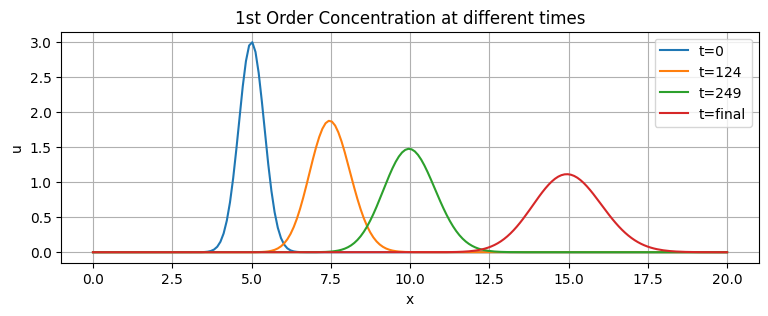

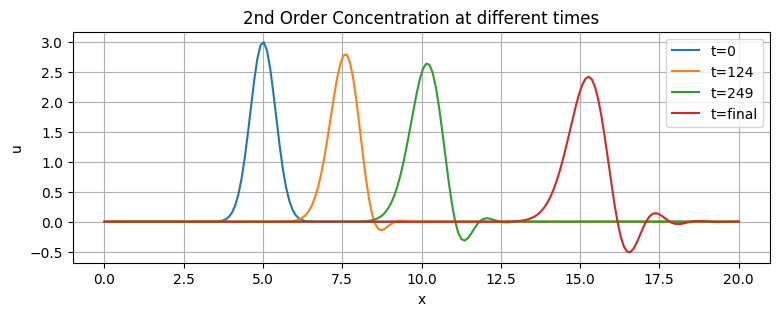

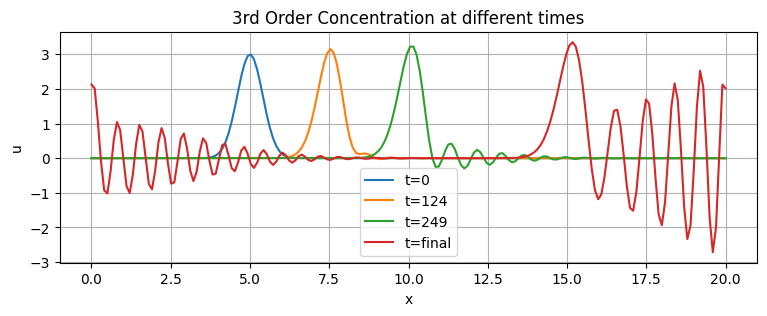

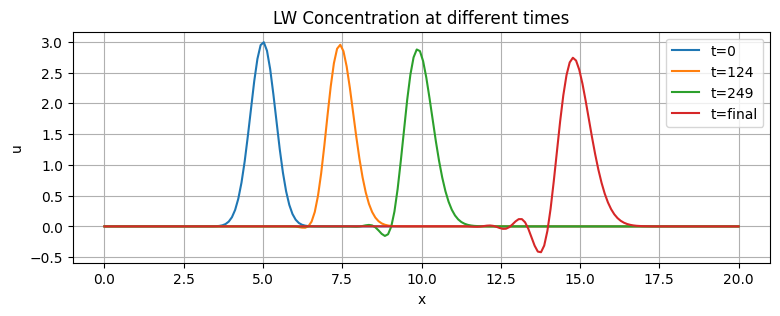

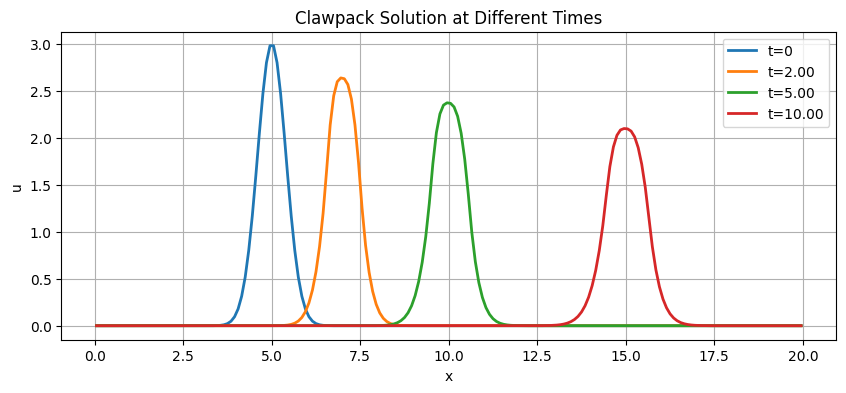

In [166]:

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_3rd_order[0, :], label='t=0')
plt.plot(x, u_3rd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_3rd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_3rd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('3rd Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_LW[0, :], label='t=0')
plt.plot(x, u_LW[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_LW[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_LW[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('LW Concentration at different times')
plt.show()

n_frames = len(claw.frames)

plt.figure(figsize=(10, 4))
plt.plot(xc, u_clawpack[0, :], label='t=0', linewidth=2)
plt.plot(xc, u_clawpack[n_frames//4, :], label=f't={t_clawpack[n_frames//4]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack[n_frames//2, :], label=f't={t_clawpack[n_frames//2]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack[-1, :], label=f't={t_clawpack[-1]:.2f}', linewidth=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Clawpack Solution at Different Times')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
from clawpack import pyclaw

# Use SharpClaw solver with WENO reconstruction
solver = pyclaw.SharpClawSolver1D(riemann_solver)
solver.weno_order = 5  # 5th order WENO
solver.time_integrator = 'SSP104'  # Correct name (10 stages, 4th order)
solver.cfl_max = 0.9  # Need to set this explicitly
solver.cfl_desired = 0.2
# Rest of setup same as before


# Boundary conditions
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

# Domain setup
x_lower = 0.0
x_upper = L
domain = pyclaw.Domain([x_lower], [x_upper], [nx])

# State setup (initial condition)
state = pyclaw.State(domain, 1)  # 1 component (scalar advection)
state.problem_data['u'] = c  # Advection velocity

# Grid
xc = state.grid.x.centers
dx_claw = state.grid.delta[0]

# Initial condition: Gaussian
state.q[0, :] = amplitude * np.exp(-(xc - x0)**2 / (2*sigma**2))

# Controller (manages time evolution)
claw = pyclaw.Controller()
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.tfinal = t_final
claw.keep_copy = True  # Store solution at each output time
claw.output_style = 1
claw.nout = 100  # Number of output times

# Run simulation
status = claw.run()

# Extract solution at different times
u_clawpack_WENO = np.zeros((len(claw.frames), nx))
t_clawpack_WENO = np.zeros(len(claw.frames))

for i, frame in enumerate(claw.frames):
    u_clawpack_WENO[i, :] = frame.q[0, :]
    t_clawpack_WENO[i] = frame.t

print(f"Clawpack ran with {len(claw.frames)} output frames")
print(f"dx = {dx_claw:.6f}, CFL used ≈ {solver.cfl_desired}")

# Plot initial vs final


2025-10-23 17:18:26,533 INFO CLAW: Solution 0 computed for time t=0.000000
2025-10-23 17:18:26,554 INFO CLAW: Solution 1 computed for time t=1.000000
2025-10-23 17:18:26,572 INFO CLAW: Solution 2 computed for time t=2.000000
2025-10-23 17:18:26,590 INFO CLAW: Solution 3 computed for time t=3.000000
2025-10-23 17:18:26,608 INFO CLAW: Solution 4 computed for time t=4.000000
2025-10-23 17:18:26,626 INFO CLAW: Solution 5 computed for time t=5.000000
2025-10-23 17:18:26,643 INFO CLAW: Solution 6 computed for time t=6.000000
2025-10-23 17:18:26,661 INFO CLAW: Solution 7 computed for time t=7.000000
2025-10-23 17:18:26,678 INFO CLAW: Solution 8 computed for time t=8.000000
2025-10-23 17:18:26,695 INFO CLAW: Solution 9 computed for time t=9.000000
2025-10-23 17:18:26,712 INFO CLAW: Solution 10 computed for time t=10.000000
Clawpack ran with 11 output frames
dx = 0.100000, CFL used ≈ 0.2


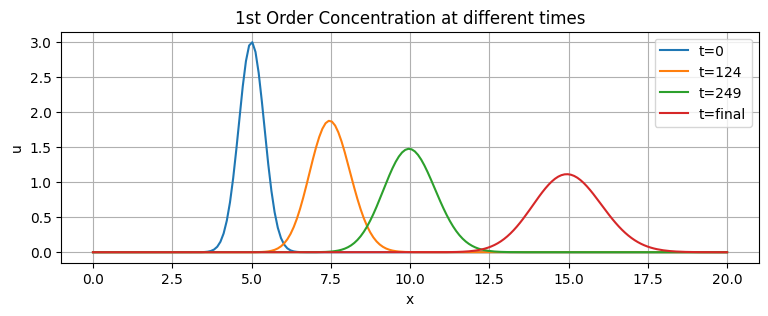

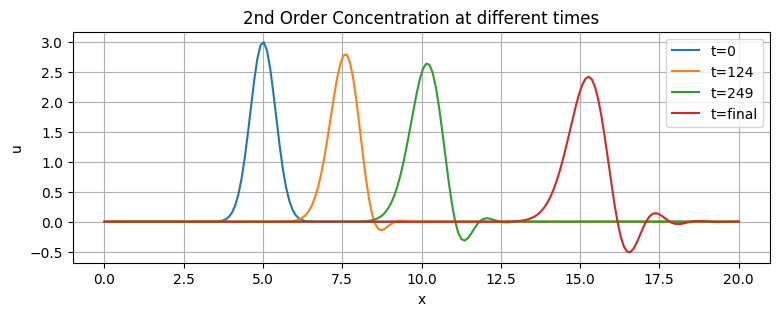

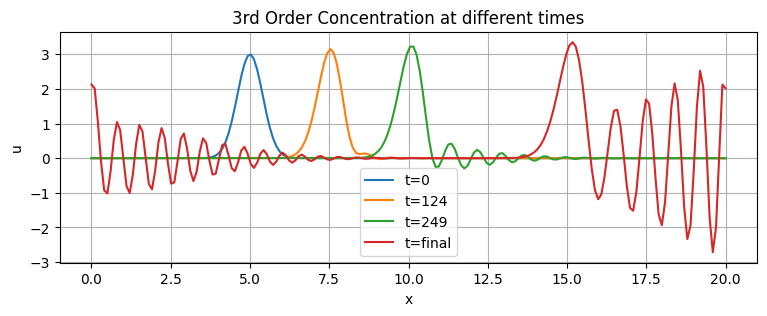

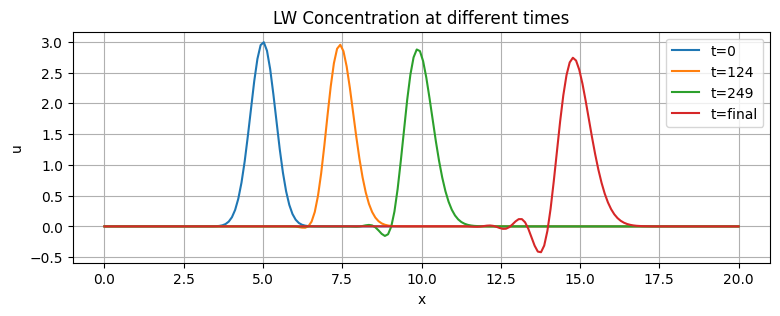

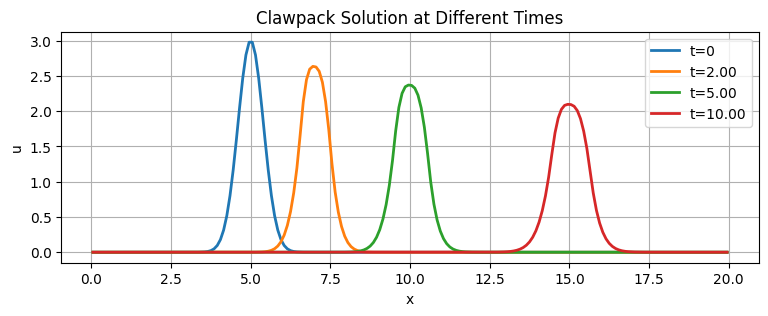

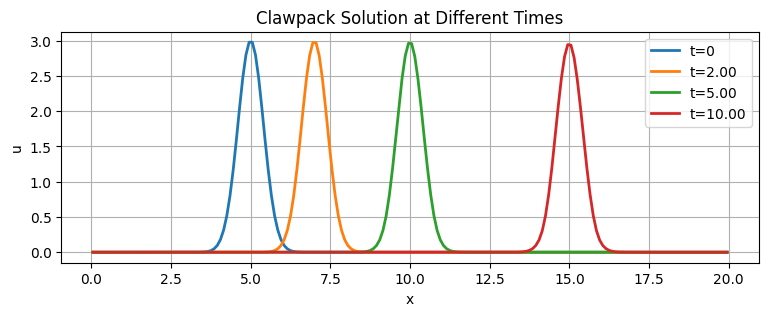

In [168]:

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_3rd_order[0, :], label='t=0')
plt.plot(x, u_3rd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_3rd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_3rd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('3rd Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_LW[0, :], label='t=0')
plt.plot(x, u_LW[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_LW[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_LW[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('LW Concentration at different times')
plt.show()

n_frames = len(claw.frames)

plt.figure(figsize=(9, 3))
plt.plot(xc, u_clawpack[0, :], label='t=0', linewidth=2)
plt.plot(xc, u_clawpack[n_frames//4, :], label=f't={t_clawpack[n_frames//4]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack[n_frames//2, :], label=f't={t_clawpack[n_frames//2]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack[-1, :], label=f't={t_clawpack[-1]:.2f}', linewidth=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Clawpack Solution at Different Times')
plt.legend()
plt.grid(True)
plt.show()



n_frames = len(claw.frames)

plt.figure(figsize=(9, 3))
plt.plot(xc, u_clawpack_WENO[0, :], label='t=0', linewidth=2)
plt.plot(xc, u_clawpack_WENO[n_frames//4, :], label=f't={t_clawpack[n_frames//4]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack_WENO[n_frames//2, :], label=f't={t_clawpack[n_frames//2]:.2f}', linewidth=2)
plt.plot(xc, u_clawpack_WENO[-1, :], label=f't={t_clawpack[-1]:.2f}', linewidth=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Clawpack Solution at Different Times')
plt.legend()
plt.grid(True)
plt.show()

In [169]:
# First, install if needed: pip install clawpack

from clawpack import pyclaw
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

## Your parameters
L = 20.0
c = 1.0
sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10
nx = 200

# Clawpack setup
riemann_solver = riemann.advection_1D  # 1D advection Riemann solver

# Create solver
solver = pyclaw.ClawSolver1D(riemann_solver)
solver.order = 2  # 2nd order with limiters (high-resolution)
solver.limiters = pyclaw.limiters.tvd.minmod  # TVD limiter for monotonicity

# CFL and timestep control
solver.cfl_max = 0.9  # Maximum CFL
solver.cfl_desired = 0.2  # Target your r=0.2

# Boundary conditions
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

# Domain setup
x_lower = 0.0
x_upper = L
domain = pyclaw.Domain([x_lower], [x_upper], [nx])

# State setup (initial condition)
state = pyclaw.State(domain, 1)  # 1 component (scalar advection)
state.problem_data['u'] = c  # Advection velocity

# Grid
xc = state.grid.x.centers
dx_claw = state.grid.delta[0]

# Initial condition: Gaussian
state.q[0, :] = amplitude * np.exp(-(xc - x0)**2 / (2*sigma**2))

# Controller (manages time evolution)
claw = pyclaw.Controller()
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.tfinal = t_final
claw.keep_copy = True
claw.output_style = 2  # Changed to 2 (specify exact times)
claw.out_times = t  # Use YOUR time array directly
claw.verbosity = 0  # Reduce output spam

# Run simulation
status = claw.run()

# Extract - now matches your nt exactly!
u_clawpack_TVD = np.zeros((nt, nx))
for i, frame in enumerate(claw.frames):
    u_clawpack_TVD[i, :] = frame.q[0, :]

print(f"Clawpack ran with {len(claw.frames)} output frames")
print(f"dx = {dx_claw:.6f}, CFL used ≈ {solver.cfl_desired}")

# Plot initial vs final


Clawpack ran with 498 output frames
dx = 0.100000, CFL used ≈ 0.2


In [170]:
from clawpack import pyclaw

# Use SharpClaw solver with WENO reconstruction
solver = pyclaw.SharpClawSolver1D(riemann_solver)
solver.weno_order = 5  # 5th order WENO
solver.time_integrator = 'SSP104'  # Correct name (10 stages, 4th order)
solver.cfl_max = 0.9  # Need to set this explicitly
solver.cfl_desired = 0.2
# Rest of setup same as before


# Boundary conditions
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

# Domain setup
x_lower = 0.0
x_upper = L
domain = pyclaw.Domain([x_lower], [x_upper], [nx])

# State setup (initial condition)
state = pyclaw.State(domain, 1)  # 1 component (scalar advection)
state.problem_data['u'] = c  # Advection velocity

# Grid
xc = state.grid.x.centers
dx_claw = state.grid.delta[0]

# Initial condition: Gaussian
state.q[0, :] = amplitude * np.exp(-(xc - x0)**2 / (2*sigma**2))

# Controller (manages time evolution)
claw = pyclaw.Controller()
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.tfinal = t_final
claw.keep_copy = True
claw.output_style = 2  # Changed to 2 (specify exact times)
claw.out_times = t  # Use YOUR time array directly
claw.verbosity = 0  # ReduTVD


# Run simulation
status = claw.run()

# Extract - now matches your nt exactly!
u_clawpack_WENO = np.zeros((nt, nx))
for i, frame in enumerate(claw.frames):
    u_clawpack_WENO[i, :] = frame.q[0, :]

print(f"Clawpack ran with {len(claw.frames)} output frames")
print(f"dx = {dx_claw:.6f}, CFL used ≈ {solver.cfl_desired}")

# Plot initial vs final


Clawpack ran with 498 output frames
dx = 0.100000, CFL used ≈ 0.2


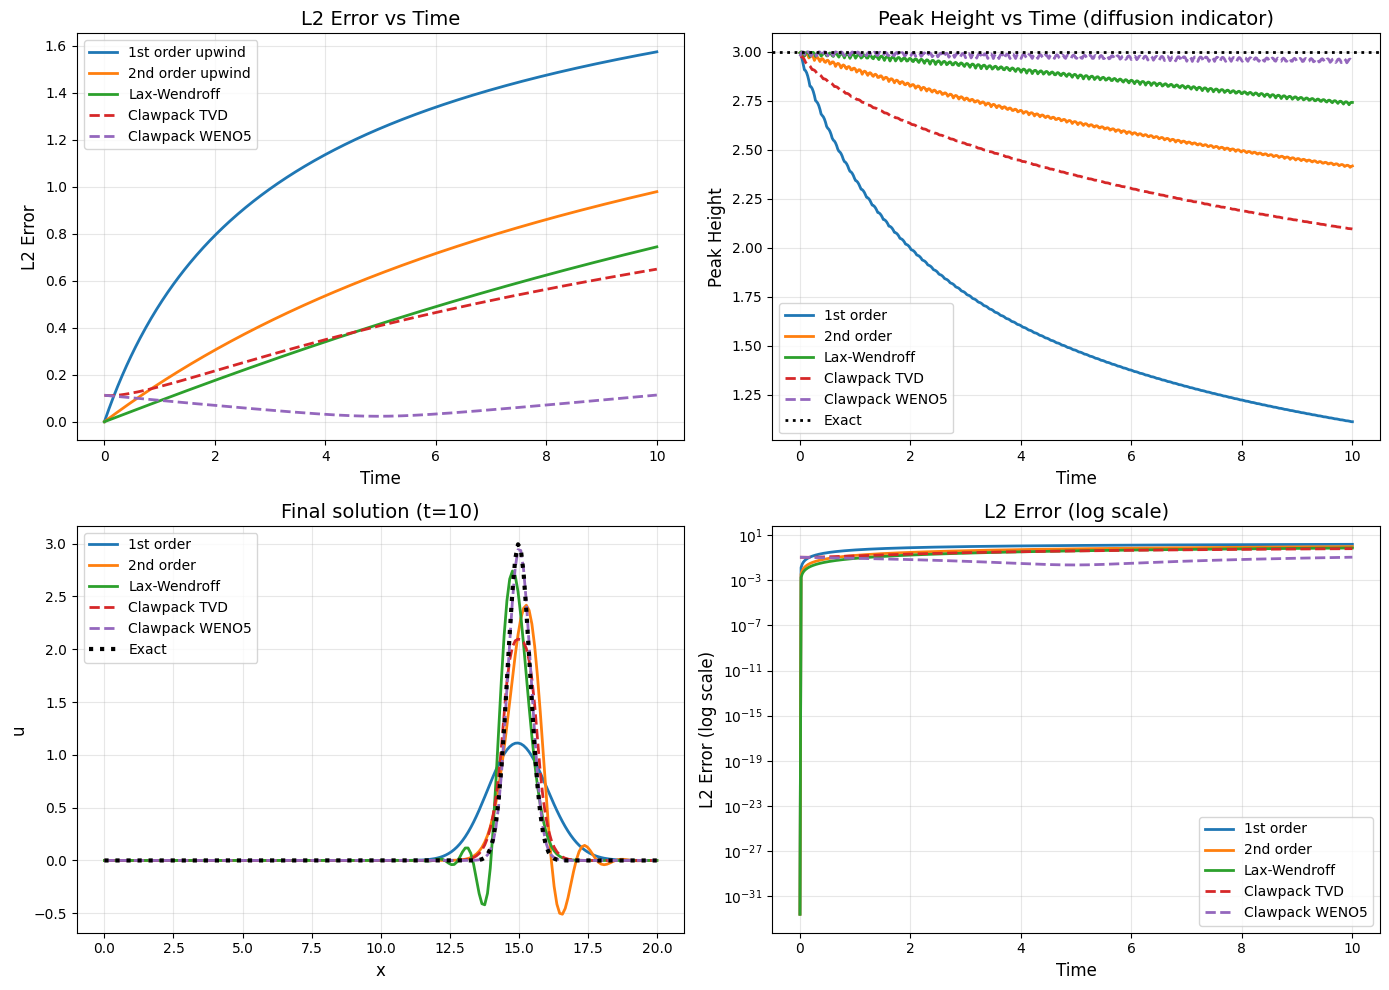

In [171]:
# Exact solution function
def exact_solution(x, t_val, c, sigma, amplitude, x0, L):
    """Exact solution: shifted Gaussian with periodic wrapping"""
    center = (x0 + c * t_val) % L
    dx_periodic = np.minimum(np.abs(x - center), L - np.abs(x - center))
    return amplitude * np.exp(-(dx_periodic**2) / (2*sigma**2))

# Interpolate Clawpack solutions to match your time grid
from scipy.interpolate import interp1d

# # Base Clawpack (TVD)
# u_claw_TVD = np.zeros((nt, nx))
# for i in range(nx):
#     interp_func = interp1d(t_clawpack, u_clawpack[:, i], 
#                            kind='cubic', fill_value='extrapolate')
#     u_claw_TVD[:, i] = interp_func(t)

# # Clawpack WENO
# u_claw_WENO = np.zeros((nt, nx))
# for i in range(nx):
#     interp_func = interp1d(t_clawpack_WENO, u_clawpack_WENO[:, i], 
#                            kind='cubic', fill_value='extrapolate')
#     u_claw_WENO[:, i] = interp_func(t)

# Compute L2 errors for all methods
L2_1st = np.zeros(nt)
L2_2nd = np.zeros(nt)
L2_LW = np.zeros(nt)
L2_claw_TVD = np.zeros(nt)
L2_claw_WENO = np.zeros(nt)

for j in range(nt):
    u_exact = exact_solution(x, t[j], c, sigma, amplitude, x0, L)
    L2_1st[j] = np.sqrt(dx * np.sum((u[j,:] - u_exact)**2))
    L2_2nd[j] = np.sqrt(dx * np.sum((u_2nd_order[j,:] - u_exact)**2))
    L2_LW[j] = np.sqrt(dx * np.sum((u_LW[j,:] - u_exact)**2))
# Direct L2 calculation - no interpolation needed!

    L2_claw_TVD[j] = np.sqrt(dx * np.sum((u_clawpack_TVD[j,:] - u_exact)**2))
    L2_claw_WENO[j] = np.sqrt(dx * np.sum((u_clawpack_WENO[j,:] - u_exact)**2))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# L2 Error comparison
axes[0,0].plot(t, L2_1st, label='1st order upwind', linewidth=2)
axes[0,0].plot(t, L2_2nd, label='2nd order upwind', linewidth=2)
axes[0,0].plot(t, L2_LW, label='Lax-Wendroff', linewidth=2)
axes[0,0].plot(t, L2_claw_TVD, label='Clawpack TVD', linewidth=2, linestyle='--')
axes[0,0].plot(t, L2_claw_WENO, label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[0,0].set_xlabel('Time', fontsize=12)
axes[0,0].set_ylabel('L2 Error', fontsize=12)
axes[0,0].set_title('L2 Error vs Time', fontsize=14)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Peak height comparison
peak_1st = np.array([np.max(u[j,:]) for j in range(nt)])
peak_2nd = np.array([np.max(u_2nd_order[j,:]) for j in range(nt)])
peak_LW = np.array([np.max(u_LW[j,:]) for j in range(nt)])
peak_claw_TVD = np.array([np.max(u_clawpack_TVD[j,:]) for j in range(nt)])
peak_claw_WENO = np.array([np.max(u_clawpack_WENO[j,:]) for j in range(nt)])

axes[0,1].plot(t, peak_1st, label='1st order', linewidth=2)
axes[0,1].plot(t, peak_2nd, label='2nd order', linewidth=2)
axes[0,1].plot(t, peak_LW, label='Lax-Wendroff', linewidth=2)
axes[0,1].plot(t, peak_claw_TVD, label='Clawpack TVD', linewidth=2, linestyle='--')
axes[0,1].plot(t, peak_claw_WENO, label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[0,1].axhline(amplitude, color='k', linestyle=':', label='Exact', linewidth=2)
axes[0,1].set_xlabel('Time', fontsize=12)
axes[0,1].set_ylabel('Peak Height', fontsize=12)
axes[0,1].set_title('Peak Height vs Time (diffusion indicator)', fontsize=14)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Final snapshot comparison
axes[1,0].plot(x, u[-1,:], label='1st order', linewidth=2)
axes[1,0].plot(x, u_2nd_order[-1,:], label='2nd order', linewidth=2)
axes[1,0].plot(x, u_LW[-1,:], label='Lax-Wendroff', linewidth=2)
axes[1,0].plot(x, u_clawpack_TVD[-1,:], label='Clawpack TVD', linewidth=2, linestyle='--')
axes[1,0].plot(x, u_clawpack_WENO[-1,:], label='Clawpack WENO5', linewidth=2, linestyle='--')
u_exact_final = exact_solution(x, t[-1], c, sigma, amplitude, x0, L)
axes[1,0].plot(x, u_exact_final, 'k:', label='Exact', linewidth=3)
axes[1,0].set_xlabel('x', fontsize=12)
axes[1,0].set_ylabel('u', fontsize=12)
axes[1,0].set_title(f'Final solution (t={t_final})', fontsize=14)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Log scale L2 error
axes[1,1].semilogy(t, L2_1st, label='1st order', linewidth=2)
axes[1,1].semilogy(t, L2_2nd, label='2nd order', linewidth=2)
axes[1,1].semilogy(t, L2_LW, label='Lax-Wendroff', linewidth=2)
axes[1,1].semilogy(t, L2_claw_TVD, label='Clawpack TVD', linewidth=2, linestyle='--')
axes[1,1].semilogy(t, L2_claw_WENO, label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[1,1].set_xlabel('Time', fontsize=12)
axes[1,1].set_ylabel('L2 Error (log scale)', fontsize=12)
axes[1,1].set_title('L2 Error (log scale)', fontsize=14)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

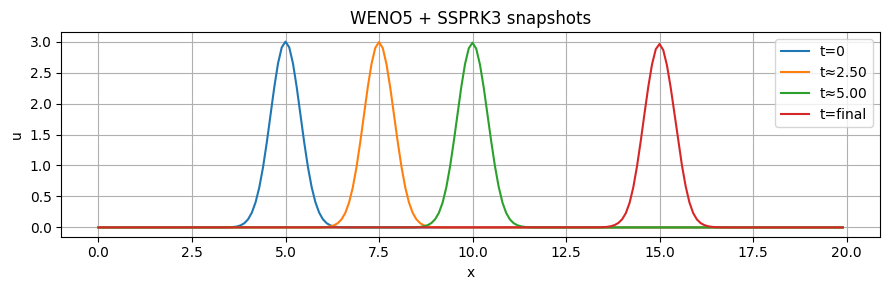

Mass: initial=3.00795393, final=3.00795393, diff=-8.17e-14
All finite: True


In [172]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Problem parameters (yours)
# ----------------------------
L = 20.0
c = 1.0

sigma = 0.4
amplitude = 3.0
x0 = L/4
t_final = 10.0

nx = 200
# Periodic-friendly grid: endpoint=False so 0 and L are not both included
x  = np.linspace(0.0, L, nx, endpoint=False)
dx = L / nx

r  = 0.2                        # Courant number
dt = r * dx / abs(c)
nt = int(np.round(t_final/dt))  # number of steps
dt = t_final/nt                 # hit t_final exactly
t  = np.linspace(0.0, t_final, nt+1)

# ----------------------------
# WENO5-JS reconstruction & RK3
# ----------------------------
def weno5_left(u, eps=1e-6):
    um2 = np.roll(u,  2); um1 = np.roll(u, 1); u0 = u
    up1 = np.roll(u, -1); up2 = np.roll(u, -2)

    # 3rd-order candidates at i+1/2
    p0 = ( 1/3)*um2 + (-7/6)*um1 + (11/6)*u0
    p1 = (-1/6)*um1 + ( 5/6)*u0  + ( 1/3)*up1
    p2 = ( 1/3)*u0  + ( 5/6)*up1 + (-1/6)*up2

    # Jiang–Shu smoothness indicators
    beta0 = (13/12)*(um2 - 2*um1 + u0)**2 + 0.25*(um2 - 4*um1 + 3*u0)**2
    beta1 = (13/12)*(um1 - 2*u0  + up1)**2 + 0.25*(um1 - up1)**2
    beta2 = (13/12)*(u0  - 2*up1 + up2)**2 + 0.25*(3*u0  - 4*up1 + up2)**2

    g0, g1, g2 = 0.1, 0.6, 0.3
    a0 = g0 / (eps + beta0)**2
    a1 = g1 / (eps + beta1)**2
    a2 = g2 / (eps + beta2)**2
    den = a0 + a1 + a2 + 1e-300  # tiny guard against divide-by-zero
    w0, w1, w2 = a0/den, a1/den, a2/den
    return w0*p0 + w1*p1 + w2*p2

def rhs_weno5(u, c, dx):
    # c>0 upwind; for general f(u) use LF splitting instead
    uL = weno5_left(u)      # left state at i+1/2, stored at index i
    F  = c * uL
    return -(F - np.roll(F, 1)) / dx  # conservative flux difference

def step_ssprk3(u, c, dx, dt):
    k1 = rhs_weno5(u, c, dx);  u1 = u + dt*k1
    k2 = rhs_weno5(u1, c, dx); u2 = 0.75*u + 0.25*(u1 + dt*k2)
    k3 = rhs_weno5(u2, c, dx); u3 = (1/3)*u + (2/3)*(u2 + dt*k3)
    return u3

# ----------------------------
# IC (yours), history storage
# ----------------------------
# IC & history for WENO
u_WENO = np.zeros((nt+1, nx))
u_WENO[0, :] = amplitude * np.exp(-((x - x0)**2) / (2.0 * sigma**2))

uw = u_WENO[0, :].copy()          # <-- was "u" before; now "uw"
for n in range(nt):
    uw = step_ssprk3(uw, c, dx, dt)
    u_WENO[n+1, :] = uw

# ----------------------------
# Plot snapshots (same style)
# ----------------------------
plt.figure(figsize=(9, 3))
plt.plot(x, u_WENO[0, :],        label='t=0')
plt.plot(x, u_WENO[nt//4, :],    label=f't≈{t[nt//4]:.2f}')
plt.plot(x, u_WENO[nt//2, :],    label=f't≈{t[nt//2]:.2f}')
plt.plot(x, u_WENO[-1, :],       label='t=final')
plt.xlabel('x'); plt.ylabel('u'); plt.legend(); plt.grid(True)
plt.title('WENO5 + SSPRK3 snapshots')
plt.tight_layout(); plt.show()

# Optional sanity checks
mass0 = u_WENO[0].sum()*dx
massf = u_WENO[-1].sum()*dx
print(f"Mass: initial={mass0:.8f}, final={massf:.8f}, diff={massf-mass0:+.2e}")
print("All finite:", np.isfinite(u_WENO).all())


In [173]:
# # prepare history array (time x space)
# u_WENO = np.zeros((nt+1, nx))
# u_WENO[0, :] = np.exp(-((x-0.3)**2)/(2*(0.05**2)))  # initial condition

# u = u_WENO[0, :].copy()
# for n in range(nt):
#     u = step_ssprk3(u, c, dx, dt)
#     u_WENO[n+1, :] = u


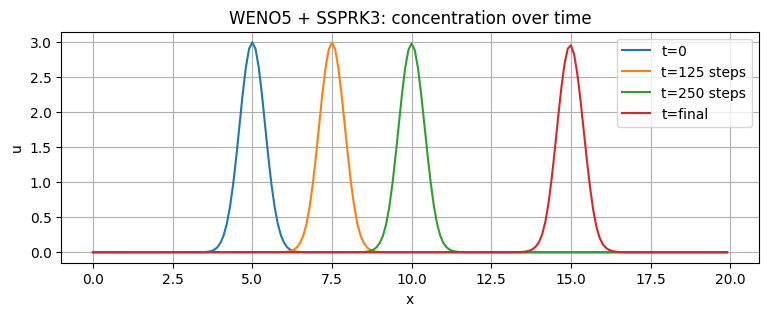

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.plot(x, u_WENO[0, :],       label='t=0')
plt.plot(x, u_WENO[nt//4, :],   label=f't={nt//4} steps')
plt.plot(x, u_WENO[nt//2, :],   label=f't={nt//2} steps')
plt.plot(x, u_WENO[-2, :],      label='t=final')
plt.xlabel('x'); plt.ylabel('u')
plt.legend(); plt.grid(True)
plt.title('WENO5 + SSPRK3: concentration over time')
plt.show()


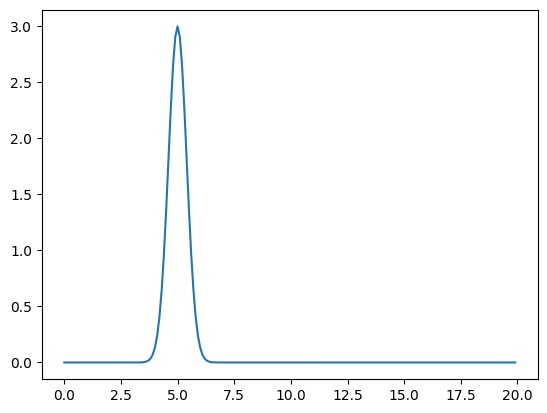

In [175]:
plt.plot(x, u_WENO[0, :],       label='t=0')

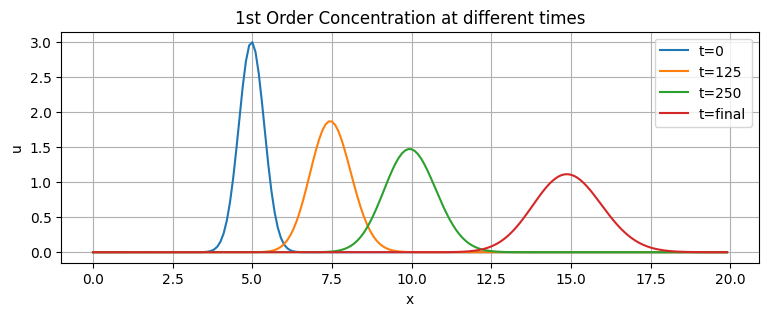

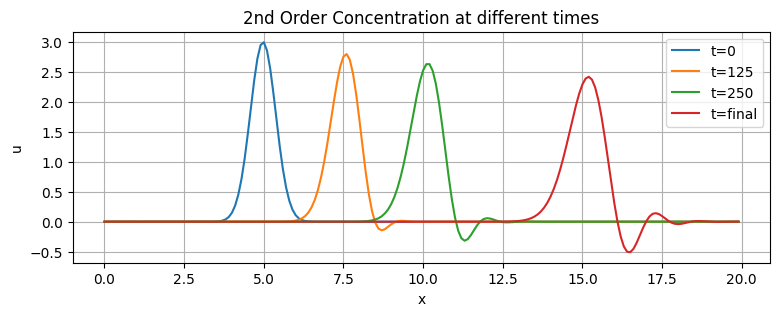

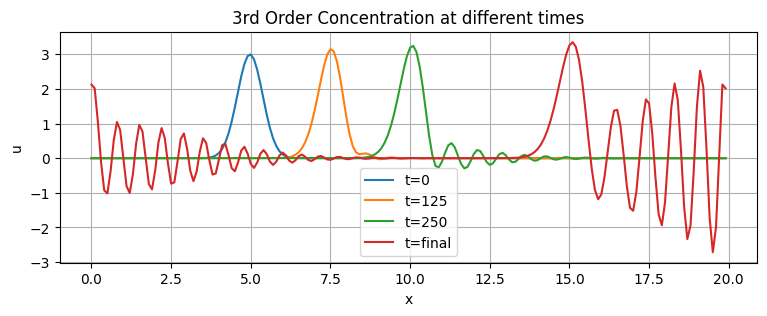

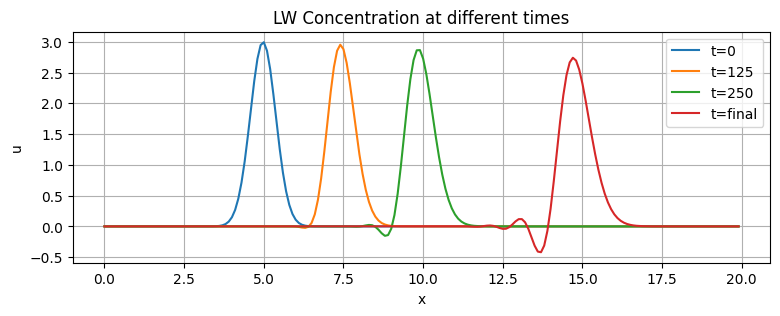

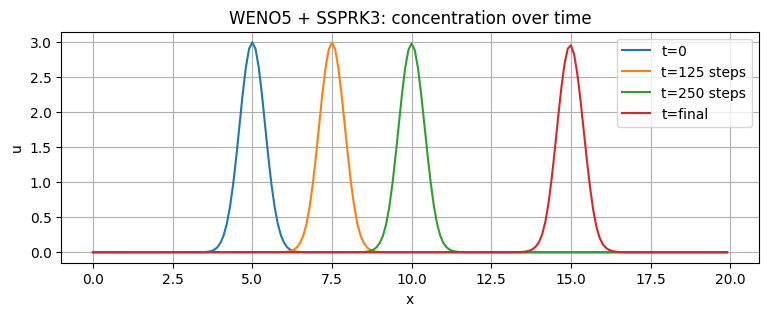

In [176]:

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u[0, :], label='t=0')
plt.plot(x, u[nt//4, :], label=f't={nt//4}')
plt.plot(x, u[nt//2, :], label=f't={nt//2}')
plt.plot(x, u[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('1st Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_2nd_order[0, :], label='t=0')
plt.plot(x, u_2nd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_2nd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_2nd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('2nd Order Concentration at different times')
plt.show()

# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_3rd_order[0, :], label='t=0')
plt.plot(x, u_3rd_order[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_3rd_order[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_3rd_order[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('3rd Order Concentration at different times')
plt.show()


# Plot a few time snapshots
plt.figure(figsize=(9, 3))
plt.plot(x, u_LW[0, :], label='t=0')
plt.plot(x, u_LW[nt//4, :], label=f't={nt//4}')
plt.plot(x, u_LW[nt//2, :], label=f't={nt//2}')
plt.plot(x, u_LW[-1, :], label='t=final')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.title('LW Concentration at different times')
plt.show()

# n_frames = len(claw.frames)

# plt.figure(figsize=(9, 3))
# plt.plot(xc, u_clawpack[0, :], label='t=0', linewidth=2)
# plt.plot(xc, u_clawpack[n_frames//4, :], label=f't={t_clawpack[n_frames//4]:.2f}', linewidth=2)
# plt.plot(xc, u_clawpack[n_frames//2, :], label=f't={t_clawpack[n_frames//2]:.2f}', linewidth=2)
# plt.plot(xc, u_clawpack[-1, :], label=f't={t_clawpack[-1]:.2f}', linewidth=2)
# plt.xlabel('x')
# plt.ylabel('u')
# plt.title('Clawpack Solution at Different Times')
# plt.legend()
# plt.grid(True)
# plt.show()



# n_frames = len(claw.frames)

# plt.figure(figsize=(9, 3))
# plt.plot(xc, u_clawpack_WENO[0, :], label='t=0', linewidth=2)
# plt.plot(xc, u_clawpack_WENO[n_frames//4, :], label=f't={t_clawpack[n_frames//4]:.2f}', linewidth=2)
# plt.plot(xc, u_clawpack_WENO[n_frames//2, :], label=f't={t_clawpack[n_frames//2]:.2f}', linewidth=2)
# plt.plot(xc, u_clawpack_WENO[-1, :], label=f't={t_clawpack[-1]:.2f}', linewidth=2)
# plt.xlabel('x')
# plt.ylabel('u')
# plt.title('Clawpack Solution at Different Times')
# plt.legend()
# plt.grid(True)
# plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.plot(x, u_WENO[0, :],       label='t=0')
plt.plot(x, u_WENO[nt//4, :],   label=f't={nt//4} steps')
plt.plot(x, u_WENO[nt//2, :],   label=f't={nt//2} steps')
plt.plot(x, u_WENO[-2, :],      label='t=final')
plt.xlabel('x'); plt.ylabel('u')
plt.legend(); plt.grid(True)
plt.title('WENO5 + SSPRK3: concentration over time')
plt.show()


In [177]:
x

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

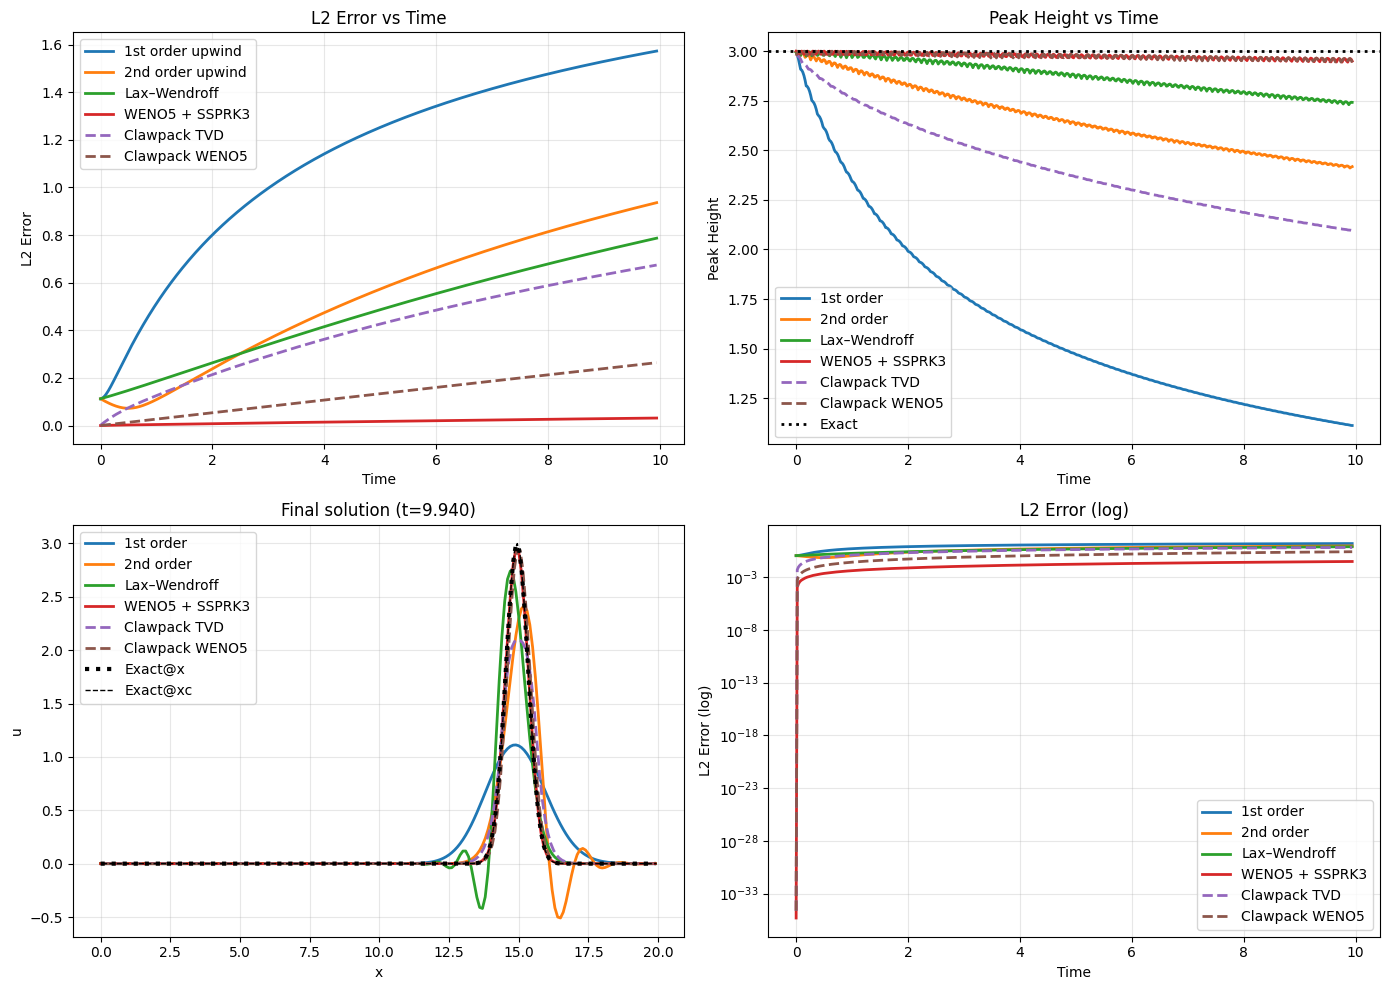

In [179]:
# ---------- pick consistent time-length across histories ----------
# Replace names below to match what you actually have in memory
histories = {
    "upwind1": u,                   # 1st-order history: shape (T1, nx)
    "upwind2": u_2nd_order,         # 2nd-order history: shape (T2, nx)
    "LW":      u_LW,                # Lax–Wendroff history: shape (T3, nx)
    "WENO":    u_WENO,              # WENO history: shape (T4, nx) (maybe nt+1)
    "clawTVD": u_clawpack_TVD,      # Clawpack TVD history: shape (Tc1, nx)
    "clawWENO":u_clawpack_WENO      # Clawpack WENO history: shape (Tc2, nx)
}

# Determine effective number of time slices we can compare
nt_eff = min([arr.shape[0] for arr in histories.values() if arr is not None])

# If your 't' has length nt or nt+1, trim to nt_eff
t_eff = t[:nt_eff]

# ---------- L2 arrays ----------
L2_1st       = np.zeros(nt_eff)
L2_2nd       = np.zeros(nt_eff)
L2_LW        = np.zeros(nt_eff)
L2_WENO      = np.zeros(nt_eff)
L2_claw_TVD  = np.zeros(nt_eff)
L2_claw_WENO = np.zeros(nt_eff)

# ---------- compute L2 with correct grid for each method ----------
for j in range(nt_eff):
    # exact on x for FD/FV histories that live on x
    uex_x = exact_solution(x, t_eff[j], c, sigma, amplitude, x0, L)

    # 1st, 2nd, LW, WENO are on x
    L2_1st[j]  = np.sqrt(dx * np.sum((histories["upwind1"][j, :]  - uex_x)**2))
    L2_2nd[j]  = np.sqrt(dx * np.sum((histories["upwind2"][j, :]  - uex_x)**2))
    L2_LW[j]   = np.sqrt(dx * np.sum((histories["LW"][j, :]       - uex_x)**2))
    L2_WENO[j] = np.sqrt(dx * np.sum((histories["WENO"][j, :]     - uex_x)**2))

    # Clawpack lives at cell centers 'xc' (half-cell shifted vs x),
    # so evaluate the exact solution on xc for a fair comparison.
    uex_xc = exact_solution(xc, t_eff[j], c, sigma, amplitude, x0, L)
    L2_claw_TVD[j]  = np.sqrt(dx * np.sum((histories["clawTVD"][j, :]  - uex_xc)**2))
    L2_claw_WENO[j] = np.sqrt(dx * np.sum((histories["clawWENO"][j, :] - uex_xc)**2))

# ---------- plots on your existing axes ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (0,0) L2 error vs time
axes[0,0].plot(t_eff, L2_1st,       label='1st order upwind', linewidth=2)
axes[0,0].plot(t_eff, L2_2nd,       label='2nd order upwind', linewidth=2)
axes[0,0].plot(t_eff, L2_LW,        label='Lax–Wendroff',     linewidth=2)
axes[0,0].plot(t_eff, L2_WENO,      label='WENO5 + SSPRK3',   linewidth=2)
axes[0,0].plot(t_eff, L2_claw_TVD,  label='Clawpack TVD',     linewidth=2, linestyle='--')
axes[0,0].plot(t_eff, L2_claw_WENO, label='Clawpack WENO5',   linewidth=2, linestyle='--')
axes[0,0].set_xlabel('Time'); axes[0,0].set_ylabel('L2 Error'); axes[0,0].set_title('L2 Error vs Time'); axes[0,0].grid(True, alpha=0.3); axes[0,0].legend()

# (0,1) peak height vs time
peak_1st       = np.max(histories["upwind1"][:nt_eff, :],  axis=1)
peak_2nd       = np.max(histories["upwind2"][:nt_eff, :],  axis=1)
peak_LW        = np.max(histories["LW"][:nt_eff, :],       axis=1)
peak_WENO      = np.max(histories["WENO"][:nt_eff, :],     axis=1)
peak_claw_TVD  = np.max(histories["clawTVD"][:nt_eff, :],  axis=1)
peak_claw_WENO = np.max(histories["clawWENO"][:nt_eff, :], axis=1)

axes[0,1].plot(t_eff, peak_1st,       label='1st order', linewidth=2)
axes[0,1].plot(t_eff, peak_2nd,       label='2nd order', linewidth=2)
axes[0,1].plot(t_eff, peak_LW,        label='Lax–Wendroff', linewidth=2)
axes[0,1].plot(t_eff, peak_WENO,      label='WENO5 + SSPRK3', linewidth=2)
axes[0,1].plot(t_eff, peak_claw_TVD,  label='Clawpack TVD', linewidth=2, linestyle='--')
axes[0,1].plot(t_eff, peak_claw_WENO, label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[0,1].axhline(amplitude, color='k', linestyle=':', label='Exact', linewidth=2)
axes[0,1].set_xlabel('Time'); axes[0,1].set_ylabel('Peak Height'); axes[0,1].set_title('Peak Height vs Time'); axes[0,1].grid(True, alpha=0.3); axes[0,1].legend()

# (1,0) final snapshot (use each method’s native grid)
axes[1,0].plot(x,  histories["upwind1"][nt_eff-1, :],  label='1st order', linewidth=2)
axes[1,0].plot(x,  histories["upwind2"][nt_eff-1, :],  label='2nd order', linewidth=2)
axes[1,0].plot(x,  histories["LW"][nt_eff-1, :],       label='Lax–Wendroff', linewidth=2)
axes[1,0].plot(x,  histories["WENO"][nt_eff-1, :],     label='WENO5 + SSPRK3', linewidth=2)
axes[1,0].plot(xc, histories["clawTVD"][nt_eff-1, :],  label='Clawpack TVD', linewidth=2, linestyle='--')
axes[1,0].plot(xc, histories["clawWENO"][nt_eff-1, :], label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[1,0].plot(x, exact_solution(x,  t_eff[-1], c, sigma, amplitude, x0, L), 'k:', label='Exact@x',  linewidth=3)
axes[1,0].plot(xc, exact_solution(xc, t_eff[-1], c, sigma, amplitude, x0, L), 'k--', label='Exact@xc', linewidth=1)
axes[1,0].set_xlabel('x'); axes[1,0].set_ylabel('u'); axes[1,0].set_title(f'Final solution (t={t_eff[-1]:.3f})'); axes[1,0].grid(True, alpha=0.3); axes[1,0].legend()

# (1,1) L2 (log)
axes[1,1].semilogy(t_eff, L2_1st,       label='1st order', linewidth=2)
axes[1,1].semilogy(t_eff, L2_2nd,       label='2nd order', linewidth=2)
axes[1,1].semilogy(t_eff, L2_LW,        label='Lax–Wendroff', linewidth=2)
axes[1,1].semilogy(t_eff, L2_WENO,      label='WENO5 + SSPRK3', linewidth=2)
axes[1,1].semilogy(t_eff, L2_claw_TVD,  label='Clawpack TVD', linewidth=2, linestyle='--')
axes[1,1].semilogy(t_eff, L2_claw_WENO, label='Clawpack WENO5', linewidth=2, linestyle='--')
axes[1,1].set_xlabel('Time'); axes[1,1].set_ylabel('L2 Error (log)'); axes[1,1].set_title('L2 Error (log)'); axes[1,1].grid(True, alpha=0.3, which='both'); axes[1,1].legend()

plt.tight_layout()
plt.show()
